In [1]:
import pandas as pd
import numpy as np

# library for similarities calculation
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance

# library for plotting image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px

# library for TSNE
from sklearn.manifold import TSNE

In [2]:
data = pd.read_csv('weather_image_recognition/file_path.csv', index_col='image_id')
color = pd.read_csv('weather_image_recognition/color_histogram.csv', index_col='image_id')
df = pd.read_csv('weather_image_recognition/embeddings.csv', index_col='id')

## measure similarity

In [3]:
def calculate_similarity(dataframe, img_input):
    """
    This function is used to calculate the euclidean distance of the images
    """
    arr = np.array([])
    for idx in dataframe.index:
        v1 = np.array(dataframe.loc[img_input, :])
        v2 = np.array(dataframe.loc[idx, :])
        arr = np.append(arr, distance.euclidean(v1, v2))
    # sort the idx from highest to lowest value
    sorted_index = np.argsort(arr)
    return sorted_index

In [11]:
def plot_images(file_paths, title):
    """
    This function is used to plot the 9 similar images, that similar to the input image from
    the similarities function
    """
    num_images = len(file_paths)
    num_rows = 2
    num_cols = (num_images + 1) // 2  # Calculate the number of columns based on the number of images

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            try:
                img = mpimg.imread(file_paths[i])
                ax.imshow(img)
                ax.axis('off')
                if i == 0:  # Add a border for the first image
                    ax.set_title("Input Image")
                else:
                    ax.set_title(f"Image {i+1}")
            except IOError:
                print(f"Unable to open image file: {file_paths[i]}")
        else:
            ax.axis('off')  # Hide unused subplot
    
    fig.suptitle(title, fontsize=20)
    
    plt.tight_layout()
    plt.show()

In [5]:
def get_file_path(paths, sorted_index, n_path=10):
    """
    This function is used to get the file paths from the given image ids
    """
    file_paths = []
    for i in sorted_index:
        idx = f"{i:07}_"
        img_path = paths.loc[idx]["file_path"]
        file_paths.append(img_path)
    # return only desired n number of paths.
    return file_paths[:n_path] 

In [7]:
number = 20000
image_id = f"{number:07}_"

# calculate the similarities, and sort by high to low
color_similarity = calculate_similarity(color, image_id)
embeddings_similarity = calculate_similarity(df, image_id)

In [8]:
# get the index of top 10 similar images
top_color = get_file_path(data, color_similarity, n_path=10)
top_embeddings = get_file_path(data, embeddings_similarity, n_path=10)

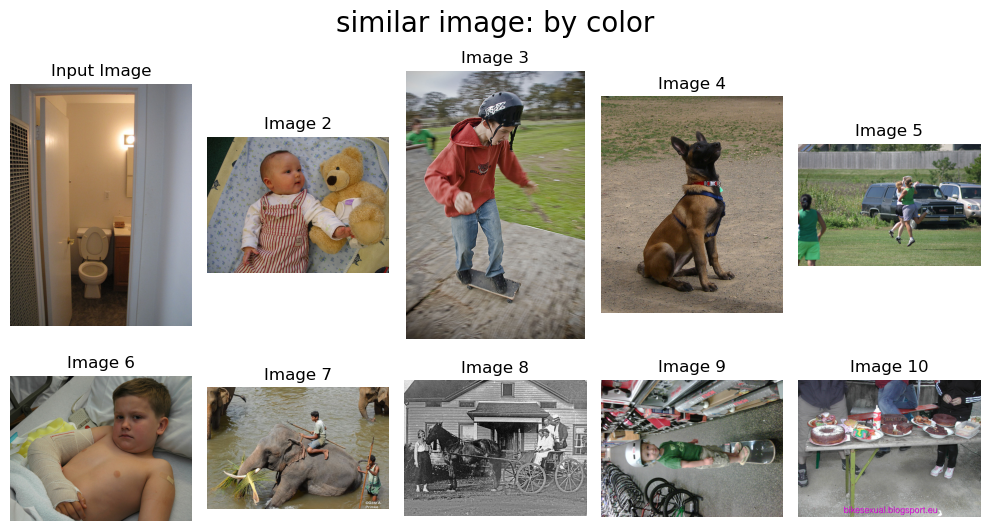

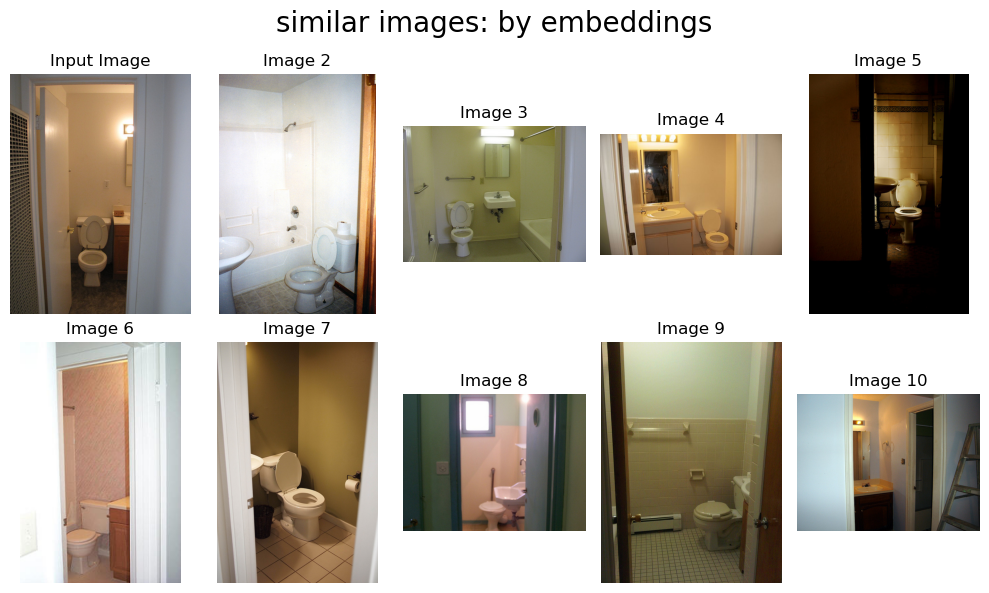

In [12]:
# plot the images
plot_images(top_color, "similar image: by color")
plot_images(top_embeddings, "similar images: by embeddings")

## TSNE

In [ ]:
# Apply t-SNE to the dataset
tsne = TSNE(n_components=2, init="pca",
            perplexity=30,
            random_state=42)
X_tsne = tsne.fit_transform(df)

# Create a DataFrame from the t-SNE results
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])

# Save t-SNE results to a CSV file
df_tsne.to_csv('tsne_results.csv', index=False)

In [25]:
# load the csv, if the results is saved before
df_tsne = pd.read_csv('tsne_results.csv')

In [28]:
# data preparation for tsne plots
data['class_'] = data['file_path'].str.split('\\').str[-2]

# convert class name to number for tsne plot
class_mapping = dict()
counter = 0
for item in list(set(data.class_)):
    class_mapping[item] = counter
    counter += 1

data['class_num'] = data['class_'].map(class_mapping)
data.head()

file_path class_  class_num
image_id                                                                     
0000000_  C:\Users\Asus\Desktop\Project\ImageRecommender...    dew          0
0000001_  C:\Users\Asus\Desktop\Project\ImageRecommender...    dew          0
0000002_  C:\Users\Asus\Desktop\Project\ImageRecommender...    dew          0
0000003_  C:\Users\Asus\Desktop\Project\ImageRecommender...    dew          0
0000004_  C:\Users\Asus\Desktop\Project\ImageRecommender...    dew          0

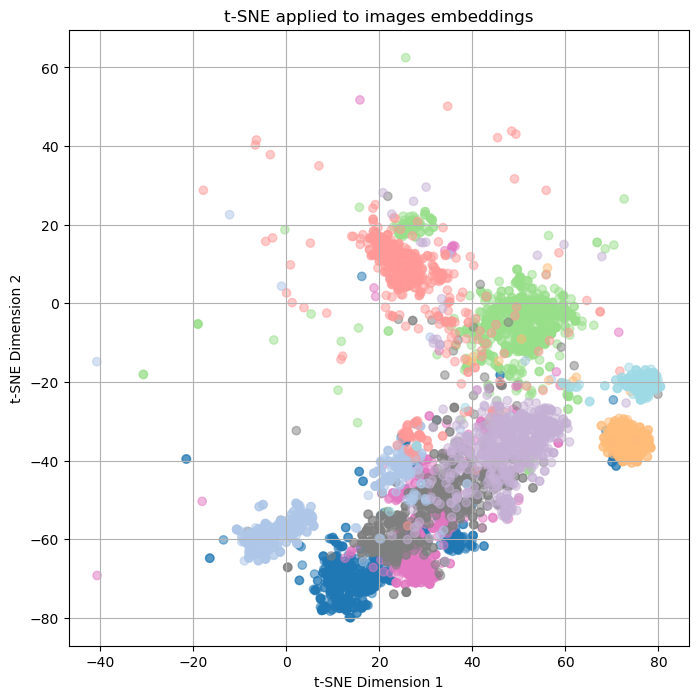

In [29]:
# Visualize the t-SNE results

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df_tsne.iloc[:5000, 0], df_tsne.iloc[:5000, 1],
           c=data.class_num.values[:5000], #loss last 32 images
           cmap='tab20', alpha=0.5)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE applied to images embeddings")
plt.grid(True)
plt.show()

In [36]:
# plotly plot

fig = px.scatter(
    df_tsne, x='TSNE1', y='TSNE2',
    color=data.class_, labels={'color': 'class_'},
    opacity=0.5
)
fig.show()